In [ ]:
# Google Colabでライブラリをアップロードする
from google.colab import files
uploaded = files.upload()

In [ ]:
# Google Colabでドライブのデータを使う
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Google Colabでライブラリをインストールする
!pip install japanize_matplotlib bottleneck tslearn

In [ ]:
# 自作関数
import MasterResearchFunction as mr

# 基本ライブラリ
import csv
import math
import os
import pickle
import random
import re
import statistics
from datetime import datetime, timedelta
from decimal import Decimal

# 数値計算とデータ処理
import bottleneck as bn
import numpy as np
import pandas as pd

# 機械学習ライブラリ
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ディープラーニングライブラリ
import tensorflow as tf
from tensorflow.keras.layers import (
    Activation,
    Add,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    LayerNormalization,
    LSTM,
    Masking,
    MaxPooling1D,
    MultiHeadAttention,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# プロットと可視化
import japanize_matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# その他のライブラリ
from fastdtw import fastdtw
from scipy import signal, stats
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from tslearn.metrics import dtw_path

In [ ]:
motion_data = mr.process_apple_watch_csv('datasets/new/sakamoto/motion/sakamoto_new_routine.csv')
eye_data = mr.process_tobii_csv('datasets/new/sakamoto/eye/sakamoto_eye_new_routine.csv')

In [ ]:
# 25秒減算坂本
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(25.659, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(25.4841, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(22.831, unit='s')
# 29秒減算渡部
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(29.766, unit='s')
# 43秒減算小寺
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(43.0029, unit='s')
# 43秒減算小寺(tri, check)
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(42.045, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(42.958, unit='s')
# 43秒減算中沢（circle, tri）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(38.43, unit='s')
# 43秒減算中沢（cross）
#eye_data["Timestamp"] = eye_data["Timestamp"] + pd.to_timedelta(11.486, unit='s')
# 43秒減算水野（cross）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(2.043, unit='s')
# 43秒減算水野（tri）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(2.171, unit='s')
# 43秒減算水野（circle, check）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(1.994, unit='s')

In [ ]:
eye_data["Timestamp"]

In [ ]:
motion_data["Timestamp"]

In [ ]:
Timestamp('2024-10-03 16:04:32.919953823')

In [ ]:
#hinase_circle_seg = mr.three_axis_spring(motion_data, train_data, [5, 5, 5], 'acc')

In [ ]:
Hz = 100

In [ ]:
a = mr.find_true_intervals(motion_data)

In [ ]:
a

In [ ]:
motion_data["Timestamp"][61303]

In [ ]:
#b = []

In [ ]:
print(i)

In [ ]:
i = i + 1

In [ ]:
i

In [ ]:
a[i]

In [ ]:
b.append([a[i][0]+80, a[i][1]-130])

In [ ]:
b

In [ ]:
len(b)

In [ ]:
del b[11]

In [ ]:
for j in range(len(b)):
  print(b[j][1] - b[j][0])

In [ ]:
for i in range(len(a)):
  print(a[i][1] - a[i][0])

In [ ]:
len(b)

In [ ]:
del b[10]

In [ ]:
c = []
for i in range(len(b)):
  c.append([motion_data["Timestamp"][b[i][0]], motion_data["Timestamp"][b[i][1]]])

In [ ]:
a = mr.find_true_intervals(motion_data)
c = []
for i in range(len(a)):
  c.append([motion_data["Timestamp"][a[i][0]], motion_data["Timestamp"][a[i][1]]])

In [ ]:
c

In [11]:
# motion_data = mr.process_apple_watch_csv('datasets/new/sakamoto/motion/sakamoto_new_routine.csv')
# eye_data = mr.process_tobii_csv('datasets/new/sakamoto/eye/sakamoto_eye_new_routine.csv')
# motion_data = mr.process_apple_watch_csv('datasets/new/kotera/motion/kotera_new_routine.csv')
# eye_data = mr.process_tobii_csv('datasets/new/kotera/eye/kotera_eye_new_routine.csv')
motion_data = mr.process_apple_watch_csv('datasets/new/mizuno/motion/mizuno_new_routine.csv')
eye_data = mr.process_tobii_csv('datasets/new/mizuno/eye/mizuno_eye_new_routine.csv')

In [12]:
a = mr.find_true_intervals(motion_data)
c = []
for i in range(len(a)):
  c.append([motion_data["Timestamp"][a[i][0]], motion_data["Timestamp"][a[i][1]]])

In [13]:
# 1. 除外するインターバルのデータフレーム作成
intervals_df = pd.DataFrame(c, columns=['start', 'end'])
intervals_df = intervals_df.sort_values('start').reset_index(drop=True)

# 2. データ全体の時間範囲の取得
start_time = eye_data['Timestamp'].min()
end_time = eye_data['Timestamp'].max()

# 3. 利用可能なインターバルの取得
available_intervals = []

if intervals_df.iloc[0]['start'] > start_time:
    available_intervals.append([start_time, intervals_df.iloc[0]['start']])

for i in range(len(intervals_df) - 1):
    gap_start = intervals_df.iloc[i]['end']
    gap_end = intervals_df.iloc[i + 1]['start']
    if gap_end > gap_start:
        available_intervals.append([gap_start, gap_end])

if intervals_df.iloc[-1]['end'] < end_time:
    available_intervals.append([intervals_df.iloc[-1]['end'], end_time])

# 4. インターバルのパラメータ設定
min_interval = 0.84  # 最小インターバル長（秒）
max_interval = 3.04  # 最大インターバル長（秒）
num_intervals = 160  # 抽出するインターバルの数

ppp = []
attempts = 0
max_attempts = num_intervals * 10  # 最大試行回数

while len(ppp) < num_intervals and attempts < max_attempts:
    attempts += 1

    # 利用可能なインターバルをフィルタリング
    suitable_intervals = [
        interval for interval in available_intervals
        if (interval[1] - interval[0]).total_seconds() >= min_interval
    ]

    if not suitable_intervals:
        print("利用可能なインターバルが足りません。")
        break

    avail_interval = random.choice(suitable_intervals)
    avail_start, avail_end = avail_interval
    avail_duration = (avail_end - avail_start).total_seconds()

    max_possible_duration = min(avail_duration, max_interval)
    duration = random.uniform(min_interval, max_possible_duration)

    latest_start_time = avail_end - pd.Timedelta(seconds=duration)
    if latest_start_time <= avail_start:
        continue

    random_offset = random.uniform(0, (latest_start_time - avail_start).total_seconds())
    start = avail_start + pd.Timedelta(seconds=random_offset)
    end = start + pd.Timedelta(seconds=duration)

    data_in_interval = eye_data[(eye_data['Timestamp'] >= start) & (eye_data['Timestamp'] <= end)]

    if not data_in_interval.empty:
        ppp.append(data_in_interval)
    else:
        continue

print(f"抽出されたインターバル数: {len(ppp)}")


抽出されたインターバル数: 160


In [5]:
sakamoto_false = ppp


In [9]:
kotera_false = ppp

In [14]:
mizuno_false = ppp

In [15]:
ppp = []

In [18]:
ppp.extend(kotera_false)

In [19]:
len(ppp)

480

In [20]:
# 削除するカラムのリスト
columns_to_drop = [
    'Sensor', 'Participant name', 'Event', 'Event value',
    'Eye movement type', 'Eye movement type index', 'Ungrouped', 'Timestamp',
    'Validity left', 'Validity right', 'Gaze event duration', 'Gaze2D_Distance',
    'Fixation_Distance', 'Gaze3D_Distance', 'Pupil_Diameter_Change',
    'GazeDirection_Distance', 'PupilPosition_Distance'
]

# ppp内の各データフレームから指定されたカラムを削除
ppp_cleaned = []

for idx, df in enumerate(ppp):
    # 存在しないカラムがある場合にエラーが出ないように、errors='ignore'を指定
    df_dropped = df.drop(columns=columns_to_drop, errors='ignore')
    ppp_cleaned.append(df_dropped)

In [ ]:
# 各範囲内のデータを格納するリストを用意します
result = []
# cの各行に対してループを回します
for start_time, end_time in c:
    # 範囲内のデータを抽出するためのマスクを作成します
    mask = (eye_data["Timestamp"] >= start_time) & (eye_data["Timestamp"] <= end_time)
    # マスクを適用してデータを抽出します
    data_in_range = eye_data.loc[mask]
    # 結果をリストに追加します
    result.append(data_in_range)

# 結果を確認します
for idx, data in enumerate(result):
    print(f"範囲 {idx+1}:")
    print(data)
    print("\n")

In [ ]:
# resultがリストである場合
first_20_results = result[0:20]

In [ ]:
len(result)

In [ ]:
# pickleファイルに出力する
with open('/Users/hinase/Downloads/mizuno_circle_eye.pkl', 'wb') as f:
    pickle.dump(result, f)

In [21]:
import pickle

#names = ['kawano', 'sakamoto', 'watabe', 'nakazawa', 'kotera']
#names = ['kotera']
names = ['sakamoto', 'watabe', 'kotera', 'nakazawa', 'mizuno']

labels = ['circle', 'cross', 'tri', 'check']

# 削除するカラムのリスト
columns_to_drop = [
    'Sensor', 'Participant name', 'Event', 'Event value',
    'Eye movement type', 'Eye movement type index', 'Ungrouped', 'Timestamp',
    'Validity left', 'Validity right', 'Gaze event duration', 'Gaze2D_Distance',
    'Fixation_Distance', 'Gaze3D_Distance', 'Pupil_Diameter_Change',
    'GazeDirection_Distance', 'PupilPosition_Distance'
]

for name in names:
    eye_data = []
    for label in labels:
        filename = f'/Users/hinase/Downloads/{name}_{label}_eye.pkl'
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            eye_data.extend(data)
    # 指定されたカラムを削除
    processed_data = []
    for df in eye_data:
        processed_df = df.drop(columns=columns_to_drop)
        processed_data.append(processed_df)
    # 各人物ごとのデータを変数に保存
    globals()[f'{name}_eye'] = processed_data

In [22]:
# リスト内包表記で一度にリストを作成
for name in names:
  label = [s for s in ['circle', 'cross', 'tri', 'check'] for _ in range(20)]
  globals()[f'{name}_label'] = label

In [23]:
# リスト'true_label'に'gesture'を80個格納
true_label = ['gesture'] * 400
# リスト'false_label'に'non-gesture'を80個格納
false_label = ['non-gesture'] * 480


In [24]:
# 既に names リストが定義されていると仮定します
X = []
label = []

for name in names:
    eye_data = globals()[f'{name}_eye']     # シーケンスのリスト
    labels = globals()[f'{name}_label']     # 対応するラベルのリスト

    for seq, lbl in zip(eye_data, labels):
        # シーケンスが空でないか確認
        if seq is not None and len(seq) > 0:
            X.append(seq)
            label.append(lbl)
        else:
            print(f"{name} のシーケンスが空です。対応するラベルをスキップします。")


In [ ]:
length = []
for i in range(len(X)):
  length.append(len(X[i]))

In [ ]:
len(X)

In [ ]:
max(length)

In [ ]:
label

In [ ]:
X[0].columns

In [25]:
X.extend(ppp_cleaned)
label=[]

In [26]:
label.extend(true_label)

In [27]:
label.extend(false_label)

In [28]:
len(X)

880

In [30]:
len(label)

880

In [ ]:
from sklearn.model_selection import train_test_split#データ分割用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
import pandas as pd

In [ ]:
len(label)

In [ ]:
ppp

In [33]:
len(X)

880

In [35]:
X_filled = []
X_scaled = []
for idx, sequence in enumerate(X):
    df = pd.DataFrame(sequence)
    # 欠損値の補間と補完
    df = df.interpolate(method='linear', limit_direction='both', axis=0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    # 残る NaN を 0 で埋める
    if df.isnull().values.any():
        print(f"シーケンス {idx} にまだ NaN が存在します。0 で埋めます。")
        df = df.fillna(0)
    # データ型を数値型に変換（必要に応じて）
    df = df.apply(pd.to_numeric, errors='coerce')
    X_filled.append(df.values)

# スケーリング前に NaN をチェック
for idx, sequence in enumerate(X_filled):
    if np.isnan(sequence).any():
        print(f"シーケンス {idx} に NaN が残っています。スケーリングをスキップします。")
        continue
    if sequence.shape[0] > 0:
        scaler = StandardScaler()
        X_scaled.append(scaler.fit_transform(sequence))
    else:
        print(f"シーケンス {idx} は空です。スケーリングをスキップします。")


/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfil

シーケンス 406 にまだ NaN が存在します。0 で埋めます。
シーケンス 409 にまだ NaN が存在します。0 で埋めます。
シーケンス 417 にまだ NaN が存在します。0 で埋めます。
シーケンス 423 にまだ NaN が存在します。0 で埋めます。
シーケンス 425 にまだ NaN が存在します。0 で埋めます。
シーケンス 429 にまだ NaN が存在します。0 で埋めます。
シーケンス 437 にまだ NaN が存在します。0 で埋めます。
シーケンス 453 にまだ NaN が存在します。0 で埋めます。
シーケンス 457 にまだ NaN が存在します。0 で埋めます。
シーケンス 458 にまだ NaN が存在します。0 で埋めます。
シーケンス 459 にまだ NaN が存在します。0 で埋めます。
シーケンス 461 にまだ NaN が存在します。0 で埋めます。
シーケンス 467 にまだ NaN が存在します。0 で埋めます。
シーケンス 480 にまだ NaN が存在します。0 で埋めます。
シーケンス 483 にまだ NaN が存在します。0 で埋めます。
シーケンス 486 にまだ NaN が存在します。0 で埋めます。
シーケンス 494 にまだ NaN が存在します。0 で埋めます。
シーケンス 497 にまだ NaN が存在します。0 で埋めます。
シーケンス 506 にまだ NaN が存在します。0 で埋めます。
シーケンス 512 にまだ NaN が存在します。0 で埋めます。
シーケンス 513 にまだ NaN が存在します。0 で埋めます。
シーケンス 524 にまだ NaN が存在します。0 で埋めます。
シーケンス 525 にまだ NaN が存在します。0 で埋めます。
シーケンス 536 にまだ NaN が存在します。0 で埋めます。
シーケンス 537 にまだ NaN が存在します。0 で埋めます。
シーケンス 545 にまだ NaN が存在します。0 で埋めます。
シーケンス 551 にまだ NaN が存在します。0 で埋めます。
シーケンス 552 にまだ NaN が存在します。0 で埋めます。
シーケンス 554 にまだ NaN が存在します。0 で埋めます。


/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/var/folders/k4/sn8gvy1j52lc_rqngc4cw4c00000gn/T/ipykernel_60821/1409082682.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfil

In [36]:
len(X_scaled)

880

In [37]:
# 1. ラベルのエンコーディング
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(label)
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# 2. データの分割（パディングの前に行う）
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.3, random_state=42
)

# 3. 訓練データとテストデータでそれぞれ最大シーケンス長を計算
max_length_train = max(len(seq) for seq in X_train_raw)
max_length_test = max(len(seq) for seq in X_test_raw)
max_length = max(max_length_train, max_length_test)

# 4. シーケンスのパディング
X_train_padded = pad_sequences(X_train_raw, maxlen=max_length, padding='post', value=0.0, dtype='float32')
X_test_padded = pad_sequences(X_test_raw, maxlen=max_length, padding='post', value=0.0, dtype='float32')

# 5. パディング後のデータに NaN が含まれていないか確認
print('NaN in X_train_padded:', np.isnan(X_train_padded).any())
print('NaN in X_test_padded:', np.isnan(X_test_padded).any())

# 必要に応じて NaN を 0 で置換
if np.isnan(X_train_padded).any():
    X_train_padded = np.nan_to_num(X_train_padded, nan=0.0)
if np.isnan(X_test_padded).any():
    X_test_padded = np.nan_to_num(X_test_padded, nan=0.0)

NaN in X_train_padded: False
NaN in X_test_padded: False


In [38]:
print(f'Number of samples in X_scaled: {len(X_scaled)}')
print(f'Number of samples in y_categorical: {len(y_categorical)}')


Number of samples in X_scaled: 880
Number of samples in y_categorical: 880


In [39]:
# 特徴量数を取得
num_features = X_train_padded.shape[2]
num_features

21

In [41]:
# 4. モデルの構築
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, num_features)))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='sigmoid'))

# 5. モデルのコンパイルと学習
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)

# 6. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 7. 予測と結果の表示
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)
print(classification_report(y_true_labels, y_pred_labels))

Epoch 1/50


/Users/hinase/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6324 - loss: 0.6334 - val_accuracy: 0.7576 - val_loss: 0.4972
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8354 - loss: 0.4171 - val_accuracy: 0.8333 - val_loss: 0.3641
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8621 - loss: 0.2924 - val_accuracy: 0.8674 - val_loss: 0.2974
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9334 - loss: 0.1907 - val_accuracy: 0.8561 - val_loss: 0.2957
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9427 - loss: 0.1594 - val_accuracy: 0.9015 - val_loss: 0.2596
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9243 - loss: 0.1848 - val_accuracy: 0.9015 - val_loss: 0.2368
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9563 - loss: 0.1412 - val_accuracy: 0.8485 - val_loss: 0.3547
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9332 - loss: 0.2019 - val_accuracy: 0.8939 - val_loss: 0.

In [51]:
input_shape = (max_length, num_features)
inputs = Input(shape=input_shape)
x = Masking(mask_value=0.)(inputs)

# num_featuresを定義（入力データの特徴量の次元数）
num_features = input_shape[1]

# Transformerブロックの定義
def transformer_block(x, num_heads, key_dim, ff_dim, rate=0.1):
    # マルチヘッド注意機構
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(rate)(attn_output)

    # 出力次元をnum_featuresに変換
    attn_output = Dense(num_features)(attn_output)

    out1 = Add()([x, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # フィードフォワードネットワーク
    ffn_output = Dense(ff_dim, activation='relu')(out1)

    # 出力次元をnum_featuresに変換
    ffn_output = Dense(num_features)(ffn_output)

    ffn_output = Dropout(rate)(ffn_output)
    out2 = Add()([out1, ffn_output])
    out2 = LayerNormalization(epsilon=1e-6)(out2)
    return out2

# Transformerブロックの適用
x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128)

# プーリングと出力層
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

# モデルの作成
model = Model(inputs=inputs, outputs=outputs)

In [52]:
# 5. モデルのコンパイルと学習
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)


Epoch 1/50


/Users/hinase/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/hinase/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/hinase/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will no

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4110 - loss: 0.7212 - val_accuracy: 0.6098 - val_loss: 0.6564
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6888 - loss: 0.6294 - val_accuracy: 0.7727 - val_loss: 0.5453
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7840 - loss: 0.5125 - val_accuracy: 0.8485 - val_loss: 0.4363
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8551 - loss: 0.4083 - val_accuracy: 0.8939 - val_loss: 0.3541
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8917 - loss: 0.3250 - val_accuracy: 0.8977 - val_loss: 0.3217
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8882 - loss: 0.2935 - val_accuracy: 0.8788 - val_loss: 0.3228
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9157 - loss: 0.2286 - val_accuracy: 0.8712 - val_loss: 0.3250
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9096 - loss: 0.2308 - val_accuracy: 0.8788 - val_loss: 0.

In [53]:
# 6. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 7. 予測と結果の表示
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)
print(classification_report(y_true_labels, y_pred_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8983 - loss: 0.4569
Test Loss: 0.46999597549438477
Test Accuracy: 0.8977272510528564
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

     gesture       0.89      0.87      0.88       117
 non-gesture       0.90      0.92      0.91       147

    accuracy                           0.90       264
   macro avg       0.90      0.90      0.90       264
weighted avg       0.90      0.90      0.90       264



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 8. 特徴量の重要度評価（Permutation Feature Importance）

# 8.1 ベースラインの性能を計算
# テストデータでの予測
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ベースラインのAccuracyを計算
baseline_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

# 8.2 特徴量ごとの重要度を計算
num_features = X_test_padded.shape[2]
feature_importances = []

for feature_idx in range(num_features):
    # テストデータをコピー
    X_test_permuted = X_test_padded.copy()

    # 特徴量をランダムにシャッフル（サンプル間でシャッフル）
    permuted_feature = X_test_permuted[:, :, feature_idx].reshape(X_test_permuted.shape[0], -1)
    np.random.shuffle(permuted_feature)
    X_test_permuted[:, :, feature_idx] = permuted_feature.reshape(X_test_permuted.shape[0], X_test_permuted.shape[1])

    # シャッフル後のデータで予測
    y_pred_permuted = model.predict(X_test_permuted)
    y_pred_classes_permuted = np.argmax(y_pred_permuted, axis=1)

    # シャッフル後のAccuracyを計算
    permuted_accuracy = accuracy_score(y_true_classes, y_pred_classes_permuted)

    # 性能の差を計算（重要度）
    importance = baseline_accuracy - permuted_accuracy
    feature_importances.append(importance)
    print(f'Feature {feature_idx + 1} Importance: {importance:.4f}')

# 8.3 特徴量重要度の可視化
feature_names = [f'Feature {i+1}' for i in range(num_features)]

plt.figure(figsize=(10, 6))
plt.barh(X[7].columns, feature_importances)
plt.xlabel('Decrease in Accuracy')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
print(X_train.shape)

In [ ]:
#  pickleファイルを読み込む
with open('/Users/hinase/Downloads/Th-s/d_nakazawa_acc_check_segments4.7new.pkl', 'rb') as f:
    data = pickle.load(f)

segx = data['d_nakazawa_check_segx']
segy = data['d_nakazawa_check_segy']
segz = data['d_nakazawa_check_segz']

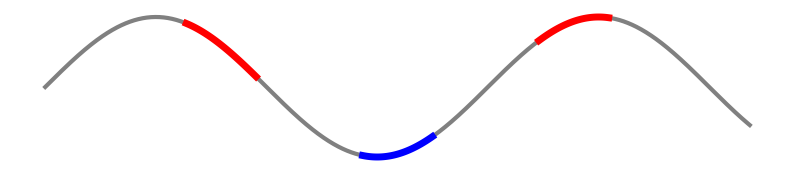

In [55]:
# Create a simple sine wave as an example of a waveform or signal
x = np.linspace(0, 10, 1000)
y = np.sin(x)

# Define the sections to be colored
color_sections = [(200, 300, 'red'), (450, 550, 'blue'), (700, 800, 'red')]

# Plot the entire waveform in gray
plt.figure(figsize=(10, 2))
plt.plot(x, y, color='gray', linewidth=3)

# Highlight the specified sections with the chosen colors
for start, end, color in color_sections:
    plt.plot(x[start:end], y[start:end], color=color, linewidth=5)

# Add an arrow to indicate the flow of data
# plt.annotate('', xy=(10, 0), xytext=(0, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=2))
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
# Remove axes for a cleaner look
plt.axis('off')
#plt.savefig("/Users/hinase/Downloads/plt.svg")

# Show plot
plt.show()

In [ ]:
import cairosvg

# SVGファイルのパス
input_svg_path = "/Users/hinase/Downloads/ss.svg"
# 出力するEPSファイルのパス
output_eps_path = "/Users/hinase/Downloads/ss.eps"

# SVGをEPSに変換
cairosvg.svg2eps(url=input_svg_path, write_to=output_eps_path)

print(f"SVG画像がEPS形式で '{output_eps_path}' に保存されました。")


In [ ]:
import os
import csv
import openpyxl
from natsort import natsorted

folder_path = '/Users/hinase/Downloads/folder3'
folder_2_path = '/Users/hinase/Downloads/folder4'

# Get Excel file names in natural order, filtering only supported Excel files
supported_extensions = ('.xlsx', '.xlsm', '.xltx', '.xltm')
files = natsorted([f for f in os.listdir(folder_path) if f.endswith(supported_extensions)])

# Loop over filenames and build absolute path for each file
for filename in files:
    filepath = os.path.join(folder_path, filename)

    # Access xlsx file and get the first sheet object
    wb = openpyxl.load_workbook(filepath)
    ws_name = wb.sheetnames[0]
    ws = wb[ws_name]

    # Convert to csv and save to folder4
    savecsv_path = os.path.join(folder_2_path, filename.rstrip(".xlsx") + ".csv")
    with open(savecsv_path, 'w', newline="") as csvfile:
        writer = csv.writer(csvfile)
        for row in ws.rows:
            writer.writerow([cell.value for cell in row])
